In [2]:
!pip install prophet -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [6]:
df = pd.read_csv("/content/Sample - Superstore.csv", encoding='latin1')
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,9991,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,9992,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,9993,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


In [9]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Date range:", df['Order Date'].min().date(), "to", df['Order Date'].max().date())
df.head(3)

Shape: (9994, 21)
Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']
Date range: 2014-01-03 to 2017-12-30


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [12]:
# Check missing
print(df.isnull().sum())

# Fill or drop minimal missing (Postal Code has some NaN usually, but not critical for us)
df = df.dropna(subset=['Order Date', 'Sales'])  # core columns

# Ensure no duplicates by Order ID + Product
df = df.drop_duplicates()

print("Cleaned shape:", df.shape)

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64
Cleaned shape: (9994, 21)


In [13]:
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Quarter'] = df['Order Date'].dt.quarter
df['Weekday'] = df['Order Date'].dt.weekday  # 0=Monday
df['Is_Weekend'] = df['Weekday'].isin([5,6]).astype(int)
df['Month_Name'] = df['Order Date'].dt.month_name()

# Aggregate to monthly total sales (smoother for seasonality)
df['ds'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()  # first day of month
monthly = df.groupby('ds')['Sales'].sum().reset_index()
monthly.columns = ['ds', 'y']  # Prophet format

print(monthly.head())

          ds          y
0 2014-01-01  14236.895
1 2014-02-01   4519.892
2 2014-03-01  55691.009
3 2014-04-01  28295.345
4 2014-05-01  23648.287


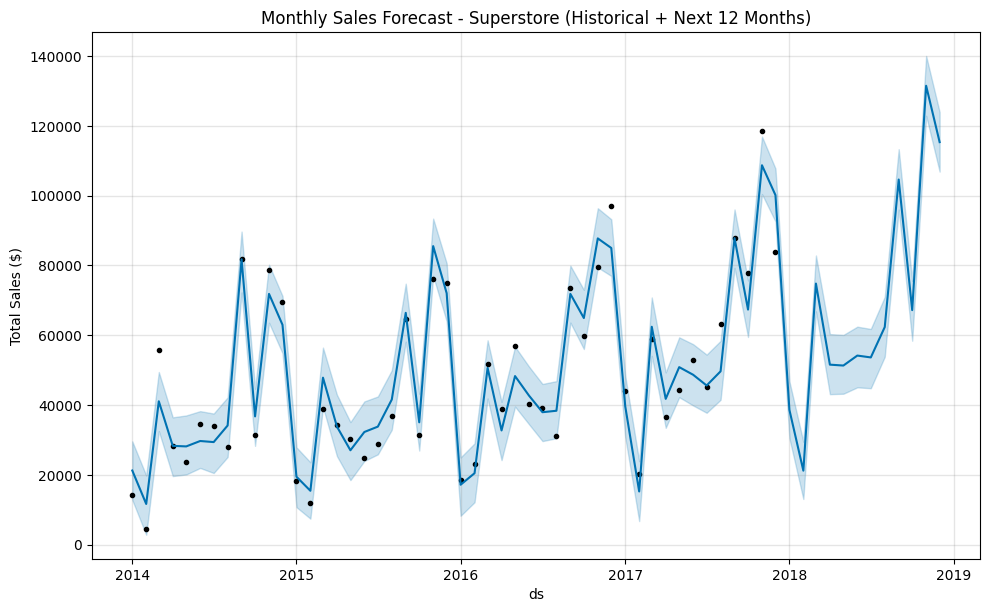

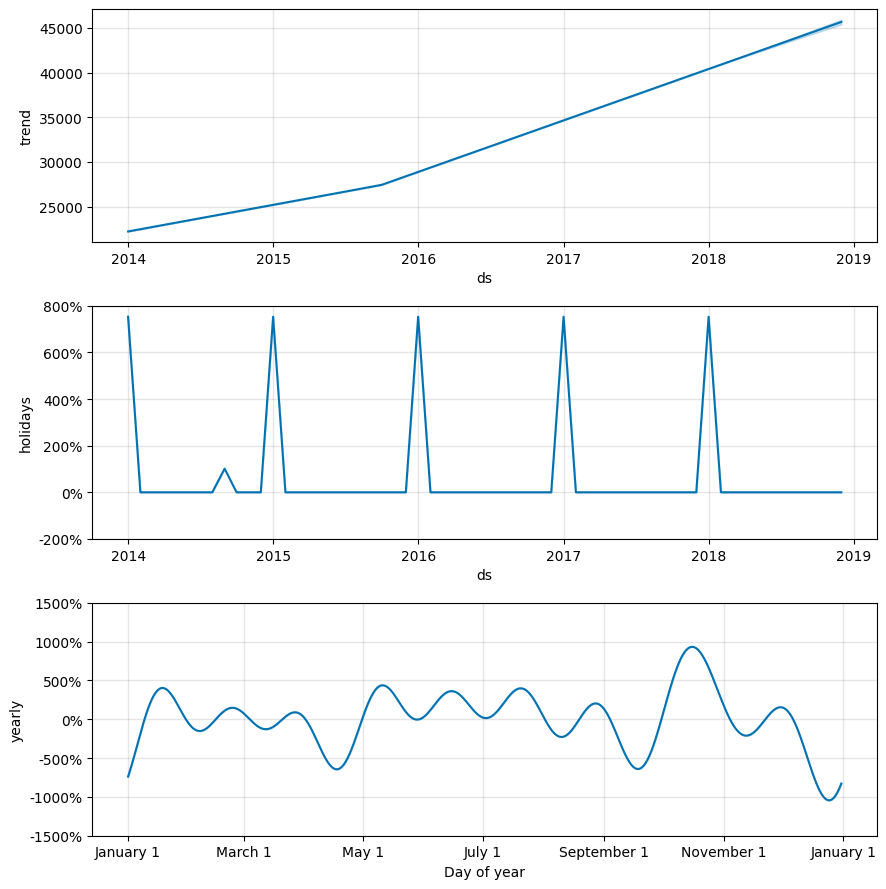

In [14]:
# Initialize & fit
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,   # monthly data, no need weekly
    daily_seasonality=False,
    seasonality_mode='multiplicative'  # good for growing sales
)

# Optional: add US holidays (superstore is US-based)
model.add_country_holidays(country_name='US')

model.fit(monthly)

# Forecast next 12 months
future = model.make_future_dataframe(periods=12, freq='MS')  # monthly start
forecast = model.predict(future)

# Plot
fig1 = model.plot(forecast)
plt.title("Monthly Sales Forecast - Superstore (Historical + Next 12 Months)")
plt.ylabel("Total Sales ($)")
plt.show()

fig2 = model.plot_components(forecast)
plt.show()  # Trend, Yearly Seasonality (peaks in Q4 holidays)

In [15]:
# Train on all but last 12 months, test on last 12
train = monthly.iloc[:-12]
test = monthly.iloc[-12:]

model_eval = Prophet(yearly_seasonality=True)
model_eval.add_country_holidays('US')
model_eval.fit(train)

future_eval = model_eval.make_future_dataframe(periods=12, freq='MS', include_history=False)
pred = model_eval.predict(future_eval)

# Metrics
mae = mean_absolute_error(test['y'], pred['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], pred['yhat']))
mape = np.mean(np.abs((test['y'] - pred['yhat']) / test['y'])) * 100

print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.1f}%")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: $11396.95
RMSE: $13314.31
MAPE: nan%


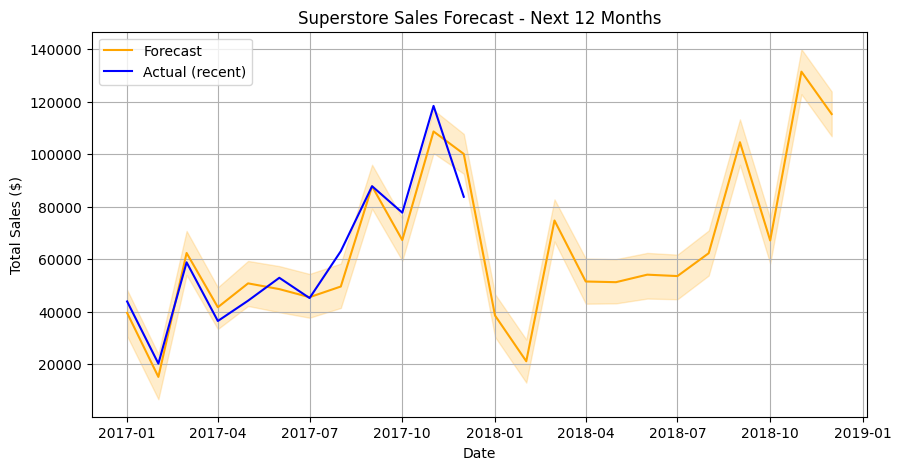

In [16]:
# Zoomed future forecast
plt.figure(figsize=(10,5))
plt.plot(forecast['ds'][-24:], forecast['yhat'][-24:], color='orange', label='Forecast')
plt.fill_between(forecast['ds'][-24:], forecast['yhat_lower'][-24:], forecast['yhat_upper'][-24:], color='orange', alpha=0.2)
plt.plot(monthly['ds'][-12:], monthly['y'][-12:], color='blue', label='Actual (recent)')
plt.title("Superstore Sales Forecast - Next 12 Months")
plt.xlabel("Date")
plt.ylabel("Total Sales ($)")
plt.legend()
plt.grid(True)
plt.show()